In [1]:
%load_ext autoreload

In [2]:
import sys
import os
import time
import torch
import pickle
import parkinson

import numpy as np
import pandas as pd
import networkx as nx

from torch import nn
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [3]:
print(os.listdir('../'))
sys.path.append('../')

['README.md', 'pyproject.toml', 'outputs', 'parkinson', 'Makefile', 'poetry.toml', 'data', 'requirements.txt', 'weights', '.git', 'notebooks', '.venv', '.gitignore', 'poetry.lock']


In [4]:
RDN = 50
N_CLASSES = 2
BATCH_SIZE = 32
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001
SAVE_PATH = '../outputs/1.0_correlation_matrix'

# Processamento dos dados

In [5]:
# lendo os arquivos de dados
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns') 

# selecionando as colunas de atlas AAL3, o atlas de conectividade cerebral
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')

# Geração da matriz de correlação utilizando o método especificado para o grupo de Parkinson
parkinson_correlation_matrix = parkinson.utils.correlation.sliding_window_correlation(parkinson_atlas_data)

# Geração da matriz de correlação utilizando o método especificado para o grupo controle
control_correlation_matrix = parkinson.utils.correlation.sliding_window_correlation(control_atlas_data)

# Concatenando grupo controle e grupo de Parkinson
# e filtrando os dados para remover entradas com NaN ou infinitos
X = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))])
X, y = parkinson.utils.data.filter_data(X, y)

# Dividindo os dados em 60 para treino, 20 para validação e 20 para teste
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=RDN, stratify=y_trainval, shuffle=True)

# Aplicando oversampling no conjunto de treino
ros = RandomOverSampler(random_state=RDN)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Criando DataLoaders
train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, batch_size=BATCH_SIZE)
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE)

100%|██████████| 66/66 [00:01<00:00, 40.64it/s]


# Treinamento

In [6]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.customMLP(input_dim=X_train.shape[1], hidden_dim=16, output_dim=2)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train)

model.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

out = parkinson.utils.train.train(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    class_weights=class_weights, 
    device=device, 
    num_epochs=N_EPOCHS, 
    patience=PATIENCE,
    lr=LR,
    path="../weights/1.0_correlation_matrix"
)

metrics = parkinson.utils.train.evaluate(model, test_loader, device, path="../weights/1.0_correlation_matrix")

train-loss: 0.1429  train-acc: 0.9890 | val-loss: 0.5003  val-acc: 0.7955:  36%|███▋      | 73/200 [00:23<00:40,  3.16it/s]

Early stopping at epoch 74


CPU times: user 4.04 s, sys: 15.3 s, total: 19.3 s
Wall time: 26 s


# Análise dos resultados

 Acurácia      F1  Precisão   Recall
 0.818182 0.79893    0.8245 0.818182


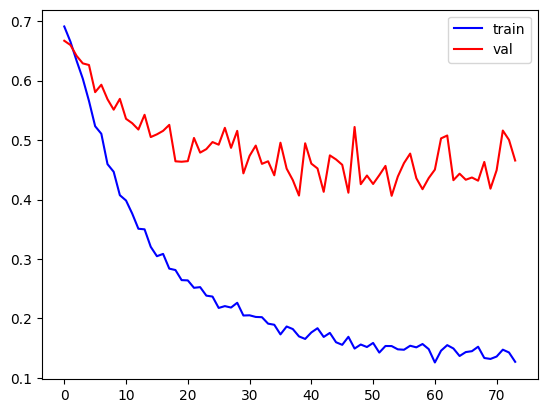

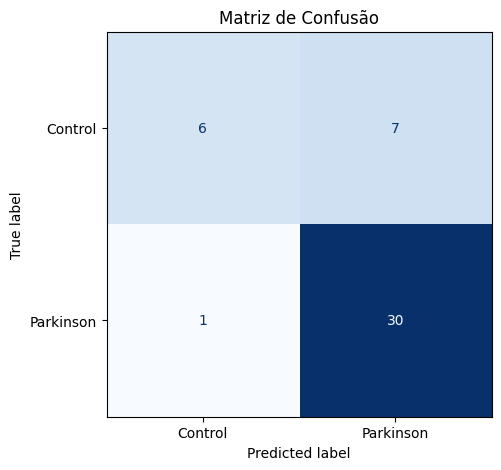

In [7]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics)
fig_loss = parkinson.utils.results.plot_losses(out['train_loss'],out['val_loss'])
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Control','Parkinson'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/loss_curve.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/confusion_matrix.png", bbox_inches='tight')